In [1]:
# importing dependencies here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer

# class imbalance
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler

from sklearn.naive_bayes import MultinomialNB

# model evaluation
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

In [2]:
# reading the email data
df = pd.read_csv("data/emails.csv", encoding='L1').rename(columns={"v1": "class", "v2": "text"})

In [3]:
# checking first 5 records
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


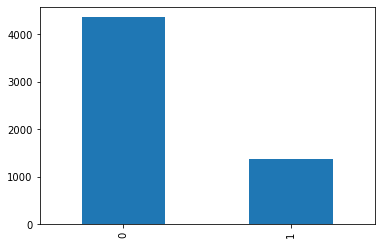

In [4]:
# checking for class imbalance
df["spam"].value_counts().plot(kind="bar")

* Class 1 = Spam
* Class 0 = Ham

#### The dataset is imbalanced. I will handle class imbalance in the model pipeline.

In [5]:
df.isnull().sum()

text    0
spam    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [7]:
# converting posts into lower case
df["clean_text"] = df["text"].str.lower()

df["clean_text"] = df["clean_text"].str.replace(
    re.compile(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*"), ""
)

# dropping emails
df["clean_text"] = df["clean_text"].str.replace(
    re.compile(r"\S+@\S+"), ""
)

# dropping punctuations
df["clean_text"] = df["clean_text"].str.replace(
    re.compile(r"[^a-z\s]"), " "
)

df["clean_text"] = df["clean_text"].str.replace("subject", "")

In [8]:
df.head()

,text,spam,clean_text
0,Subject: naturally irresistible your corporate...,1,naturally irresistible your corporate identi...
1,Subject: the stock trading gunslinger fanny i...,1,the stock trading gunslinger fanny is merri...
2,Subject: unbelievable new homes made easy im ...,1,unbelievable new homes made easy im wanting...
3,Subject: 4 color printing special request add...,1,color printing special request additional...
4,"Subject: do not have money , get software cds ...",1,do not have money get software cds from he...


In [9]:
X = df["clean_text"].values
y = df["spam"].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42)

In [11]:
nb_pipe = imb_make_pipeline(
    CountVectorizer(stop_words="english"), RandomOverSampler(), MultinomialNB(class_prior=None, fit_prior=True)
)

In [12]:
nb_pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('randomoversampler', RandomOverSampler()),
                ('multinomialnb', MultinomialNB())])

In [13]:
y_pred = nb_pipe.predict(X_test)

# y_probability
y_proba = nb_pipe.predict_proba(X_test)[:, 1]

In [14]:
# precision recall score
average_precision = average_precision_score(y_test, y_proba)
print(f"Average Precision-Recall Score: {average_precision:.2f}")

Average Precision-Recall Score: 0.98


In [15]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.97      0.99      0.98      0.97      1063
          1       0.98      0.97      0.99      0.97      0.98      0.96       369

avg / total       0.99      0.99      0.98      0.99      0.98      0.96      1432



In [16]:
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")

ROC-AUC Score: 1.00


In [17]:
from sklearn.model_selection import cross_validate
cv_score = cross_validate(nb_pipe, X, y, cv=8, scoring="accuracy")["test_score"].mean() 

In [18]:
cv_score

0.9921438547486033